# Unitary ansatz entering the VQE

The final energy output of a VQE calculation will crucially depend on the ansatz/form of the parameterized unitary $\hat U(\boldsymbol{\theta})$ employed in state preparation. Here we review two popular approaches, the unitary coupled cluster and qubit coupled cluster methodologies, and benchmark them for energy calculations of small molecules.

In [2]:
import numpy as np
import tequila as tq
from utility import *
import matplotlib.pyplot as plt
threshold = 1e-6 #Cutoff for UCC MP2 amplitudes and QCC ranking gradients

## Unitary Coupled Cluster (UCC)

The UCC ansatz is obtained by 'unitarizing' the traditional coupled cluster ansatz,
$$ e^{\hat T} \rightarrow e^{\hat T - \hat T^\dagger} \equiv \hat U_{\text{UCC}}$$


Due to non-commutativity of terms in $\hat T - \hat T^\dagger$, the UCC ansatz does not have a straightforward decomposition in terms of circuit primitives implementable on the quantum computer. Therefore, to obtain a form which can be compiled, we employ the Trotter approximation. The accuracy of the circuit ansatz relative to the exact UCC operator will be dependent on how many Trotter steps are employed. The number of Trotter steps is commonly set to its minimal value of one to avoid excessive circuit depth.

In [4]:
trotter_steps = 1

### H2 in STO-3G basis

Below is a sample VQE simulation using the UCCSD ansatz compiled using a single trotter step for H$_2$ in minimal basis at $R=2.5$ (Angstrom). For comparison, we can run FCI to obtain the true ground state energy.


In [5]:
xyz_data = get_molecular_data('h2', geometry=2.5, xyz_format=True)
basis='sto-3g'

h2 = tq.quantumchemistry.Molecule(geometry=xyz_data, basis_set=basis)

print('Number of spin-orbitals (qubits): {} \n'.format(2*h2.n_orbitals))

E_FCI = h2.compute_energy(method='fci')

print('FCI energy: {}'.format(E_FCI))

Number of spin-orbitals (qubits): 4 

FCI energy: -0.9360549199436612


The UCCSD VQE optimization is of the form
$$E = \min_{\boldsymbol{\theta}} \langle \text{HF} | \hat U_{\text{UCC}}^\dagger(\boldsymbol{\theta}) \hat H  \hat U_{\text{UCC}} (\boldsymbol{\theta}) | \text{HF} \rangle $$
To expedite the optimization process, we can set the initial guess of the amplitudes to zero, i.e. the optimization will begin at the Hartree Fock state. This heuristic is best suited for when Hartree Fock is believed to be in qualitative agreement with the true ground state. To further alleviate quantum resources, we can estimate the amplitudes using classical electronic structure methods (here, MP2 perturbation theory), and only include the unitaries with non-zero estimated amplitudes.

In [4]:
H = h2.make_hamiltonian()

print("\nHamiltonian has {} terms\n".format(len(H)))

U_UCCSD = h2.make_uccsd_ansatz(initial_amplitudes='MP2',threshold=threshold, trotter_steps=trotter_steps)

E = tq.ExpectationValue(H=H, U=U_UCCSD)

print('\nNumber of UCCSD amplitudes: {} \n'.format(len(E.extract_variables())))

print('\nStarting optimization:\n')

result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()}, tol=threshold)

print('\nObtained UCCSD energy: {}'.format(result.energy))


Hamiltonian has 15 terms


Number of UCCSD amplitudes: 1 


Starting optimization:

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 32 expectationvalues

active variables : 1

E=-0.70294360  angles= {(1, 0, 1, 0): 0.0}  samples= None
E=-0.92698008  angles= {(1, 0, 1, 0): -0.5644201636314392}  samples= None
E=-0.93354955  angles= {(1, 0, 1, 0): -0.756477668453395}  samples= None
E=-0.93605486  angles= {(1, 0, 1, 0): -0.6900732739717247}  samples= None
E=-0.93605492  angles= {(1, 0, 1, 0): -0.6904080632337539}  samples= None
E=-0.93605492  angles= {(1, 0, 1, 0): -0.6904070264134937}  samples= None
Optimization terminated successfully.
         Current function value: -0.936055
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6

Obtained UCCSD energy: -0.9

We see that the converged UCCSD energy is in exact agreement with the FCI energy, as expected for a $2$-electron system. 

### H2O in 6-31G basis

Now let us try a larger problem of H$_2$O in 6-31G basis. However, we will restrict the active space. The unrestricted problem leads to a $14$-qubit Hamiltonian, and $34$ UCCSD amplitudes to optimize even after neglecting the zero MP2 amplitudes. Therefore, we will remove some orbital degrees of freedom which are less important in accurately describing the electronic structure. By freezing all orbitals other than $0b_1$, $1b_1$, $2a_1$, and $3a_1$, we reduce the problem to an $8$-qubit Hamiltonian with $8$ UCCSD variational amplitudes.

In [5]:
xyz_data = get_molecular_data('h2o', geometry=1, xyz_format=True)

basis = '6-31g'
active = {'B1':[0,1], 'A1':[2,3]}
h2o = tq.quantumchemistry.Molecule(geometry=xyz_data, basis_set = basis, active_orbitals = active)

print('Number of spin-orbitals (qubits): {} \n'.format(2*h2o.n_orbitals))

E_FCI = h2o.compute_energy(method='fci')

print('FCI energy: {}'.format(E_FCI))

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
Number of spin-orbitals (qubits): 8 

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for fci.
FCI energy: -75.98980140961186


We will then run the UCCSD VQE simulation (***warning: tq.minimize will take several minutes - 1 hour + to converge for a VQE instance of this size.*** Smaller active spaces can be employed to lower VQE simulation runtimes).

In [6]:
H = h2o.make_hamiltonian()

print("\nHamiltonian has {} terms\n".format(len(H)))

U_UCCSD = h2o.make_uccsd_ansatz(initial_amplitudes='MP2',threshold=threshold, trotter_steps=trotter_steps)

E = tq.ExpectationValue(H=H, U=U_UCCSD)

print('\nNumber of UCCSD amplitudes: {} \n'.format(len(E.extract_variables())))

print('\nStarting optimization:\n')

result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()}, tol=1e-4)

print('\nObtained UCCSD energy: {}'.format(result.energy))


Hamiltonian has 185 terms


Number of UCCSD amplitudes: 8 


Starting optimization:

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 512 expectationvalues

active variables : 8

E=-75.98071144  angles= {(3, 0, 3, 0): 0.0, (3, 1, 2, 0): 0.0, (2, 1, 2, 1): 0.0, (2, 0, 3, 1): 0.0, (3, 1, 3, 1): 0.0, (3, 0, 2, 1): 0.0, (2, 0, 2, 0): 0.0, (2, 1, 3, 0): 0.0}  samples= None
E=-75.57991345  angles= {(3, 0, 3, 0): -0.1516876220703125, (3, 1, 2, 0): -0.04468536376953125, (2, 1, 2, 1): -0.06198883056640625, (2, 0, 3, 1): -0.04468536376953125, (3, 1, 3, 1): -0.0497894287109375, (3, 0, 2, 1): 0.15348052978515625, (2, 0, 2, 0): -0.06015777587890625, (2, 1, 3, 0): 0.15348052978515625}  samples= None
E=-75.98420833  angles= {(3, 0, 3, 0): -0.012046029637663564, (3, 1, 2, 0): -0.0035486166174326273, (2, 1, 

We obtain a UCCSD energy within chemical accuracy (< 1.6 miliHartree from FCI energy) for the H$_2$O molecule near equilibrium geometry. As the bond distance approaches the dissociation limit, the energy deviation from FCI is typically expected to increase as electronic correlations increase during covalent bond-breaking. Furthermore, as HF becomes energetically more distant from the FCI wavefunction, the initial guess of all amplitudes being zero may lead to a local minimum. One can then instead initialize the amplitudes using random guesses, and repeat for $n$ samples to attempt to find the global minimum. To facilitate this, one can run the commented lines below. This will execute $n$ instances of tq.minimize for uniformly random initial parameters in interval $[0, 2\pi]$ and return the lowest optimization result.

In [ ]:
#n=10
#result = minimize_E_random_guesses(objective=E, method='BFGS', tol=1e-4, n=n)

## Qubit Coupled Cluster (QCC)

In contrast to UCC, the QCC methodology makes no direct reference to fermionic algebra and seeks to construct an efficient ansatz directly in qubit-space by finding multi-qubit Pauli strings (entanglers) which lower energy. This is done through an energy-lowering heuristic employing the energy gradient with respect to a Pauli strings variational amplitude. As opposed to UCCSD, the circuit depth and number of parameter is chosen to meet hardware limitations, i.e. one must choose how many exponentiated Pauli strings will be entering the QCC ansatz.

### H2 in STO-3G basis

Below we perform the entangler screening protocol for H2 in minimal basis, and obtain one grouping of entanglers with non-zero energy gradient. We then select one of them to be used in the QCC VQE simulation.

In [16]:
xyz_data = get_molecular_data('h2', geometry=2.5, xyz_format=True)
basis='sto-3g'

h2 = tq.quantumchemistry.Molecule(geometry=xyz_data, basis_set='sto-3g')

hf_reference = hf_occ(2*h2.n_orbitals, h2.n_electrons)

H = h2.make_hamiltonian()

print("\nHamiltonian has {} terms\n".format(len(H)))

#Define number of entanglers to enter ansatz
n_ents = 1

#Rank entanglers using energy gradient criterion
ranked_entangler_groupings = generate_QCC_gradient_groupings(H.to_openfermion(), 
                                                             2*h2.n_orbitals, 
                                                             hf_reference, 
                                                             cutoff=threshold)

print('Grouping gradient magnitudes (Grouping : Gradient magnitude):')
for i in range(len(ranked_entangler_groupings)):
    print('{} : {}'.format(i+1,ranked_entangler_groupings[i][1]))


entanglers = get_QCC_entanglers(ranked_entangler_groupings, n_ents, 2*h2.n_orbitals)

print('\nSelected entanglers:')
for ent in entanglers:
    print(ent)




Hamiltonian has 15 terms

Grouping gradient magnitudes (Grouping : Gradient magnitude):
1 : 0.2822

Selected entanglers:
1.0 [X0 Y1 X2 X3]


Once the QCC ranking procedure has been ran, we can simulate the QCC VQE optimization with the generated entanglers. The VQE optimization for the QCC ansatz is of the form
$$E = \min_{\boldsymbol{\Omega}, \boldsymbol{\tau}} \langle \boldsymbol{\Omega} | U_{\text{ENT}}^\dagger (\boldsymbol{\tau}) \hat H  U_{\text{ENT}} (\boldsymbol{\tau}) | \boldsymbol{\Omega} \rangle $$
where $\boldsymbol{\Omega}$ denote collective Euler angles parameterizing single-qubit rotations, and $\boldsymbol{\tau}$ are entangler amplitudes. 

In [17]:
#Mean-field part of U (Omega):    
U_MF = construct_QMF_ansatz(n_qubits = 2*h2.n_orbitals)
#Entangling part of U:
U_ENT = construct_QCC_ansatz(entanglers)

U_QCC = U_MF + U_ENT

E = tq.ExpectationValue(H=H, U=U_QCC)

initial_vals = init_qcc_params(hf_reference, E.extract_variables())

#Minimize wrt the entangler amplitude and MF angles:
result = tq.minimize(objective=E, method="BFGS", initial_values=initial_vals, tol=threshold)

print('\nObtained QCC energy ({} entanglers): {}'.format(len(entanglers), result.energy))

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 18 expectationvalues

active variables : 9

E=-0.70294360  angles= {gamma_3: 0.0, beta_1: 3.141592653589793, gamma_0: 0.0, tau_0: 0.0, gamma_2: 0.0, gamma_1: 0.0, beta_2: 0.0, beta_0: 3.141592653589793, beta_3: 0.0}  samples= None
E=-0.77938639  angles= {gamma_3: 0.0, beta_1: 3.141592653589793, gamma_0: 0.0, tau_0: 0.2822100520133972, gamma_2: 0.0, gamma_1: 0.0, beta_2: 0.0, beta_0: 3.141592653589793, beta_3: 0.0}  samples= None
E=-0.93592356  angles= {gamma_3: 0.0, beta_1: 3.141592653589793, gamma_0: 0.0, tau_0: 1.411050260066986, gamma_2: 0.0, gamma_1: 0.0, beta_2: 0.0, beta_0: 3.141592653589793, beta_3: 0.0}  samples= None
E=-0.93603455  angles= {gamma_3: 0.0, beta_1: 3.141592653589793, gamma_0: 0.0, tau_0: 1.3689076316049542, gamma_2: 0.0, 

We see that the QCC energy converged to the FCI energy with only a single entangler! 

### H2O in 6-31G basis

Let us move on to the problem of H$_2$O in 6-31G basis using the same active space as the UCCSD example.

In [6]:
xyz_data = get_molecular_data('h2o', geometry=1, xyz_format=True)

basis = '6-31g'
active = {'B1':[0,1], 'A1':[2,3]}
h2o = tq.quantumchemistry.Molecule(geometry=xyz_data, basis_set = basis, active_orbitals = active)
hf_reference = hf_occ(2*h2o.n_orbitals, h2o.n_electrons)


H = h2o.make_hamiltonian()

print("\nHamiltonian has {} terms\n".format(len(H)))

#Define number of entanglers to enter ansatz
n_ents = 6

#Rank entanglers using energy gradient criterion
ranked_entangler_groupings = generate_QCC_gradient_groupings(H.to_openfermion(), 
                                                             2*h2o.n_orbitals, 
                                                             hf_reference, 
                                                             cutoff=threshold)

print('Grouping gradient magnitudes (Grouping : Gradient magnitude):')
for i in range(len(ranked_entangler_groupings)):
    print('{} : {}'.format(i+1,ranked_entangler_groupings[i][1]))

entanglers = get_QCC_entanglers(ranked_entangler_groupings, n_ents, 2*h2o.n_orbitals)

print('\nSelected entanglers:')
for ent in entanglers:
    print(ent)

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.

Hamiltonian has 185 terms

Grouping gradient magnitudes (Grouping : Gradient magnitude):
1 : 0.0758
2 : 0.0371
3 : 0.0371
4 : 0.031
5 : 0.0301
6 : 0.0249
7 : 0.0198
8 : 0.0198
9 : 0.0173
10 : 0.0173
11 : 0.0
12 : 0.0

Selected entanglers:
1.0 [X0 Y1 X6 X7]
1.0 [X0 Y3 X5 X6]
1.0 [X1 Y2 X4 X7]
1.0 [X2 Y3 X4 X5]
1.0 [X0 Y1 X4 X5]
1.0 [X2 Y3 X6 X7]


With the 6 chosen entanglers, we can then run the QCC VQE simulation.

In [7]:
#Mean-field part of U (Omega):    
U_MF = construct_QMF_ansatz(n_qubits = 2*h2o.n_orbitals)
#Entangling part of U:
U_ENT = construct_QCC_ansatz(entanglers)

U_QCC = U_MF + U_ENT

E = tq.ExpectationValue(H=H, U=U_QCC)

initial_vals = init_qcc_params(hf_reference, E.extract_variables())

#Minimize wrt the entangler amplitude and MF angles:
result = tq.minimize(objective=E, method="BFGS", initial_values=initial_vals, tol=1.e-4)


print('\nObtained QCC energy ({} entanglers): {}'.format(len(entanglers), result.energy))

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 44 expectationvalues

active variables : 22

E=-75.98071144  angles= {gamma_7: 0.0, tau_0: 0.0, gamma_5: 0.0, beta_1: 3.141592653589793, tau_3: 0.0, tau_5: 0.0, tau_4: 0.0, gamma_1: 0.0, beta_0: 3.141592653589793, gamma_3: 0.0, gamma_4: 0.0, beta_5: 0.0, beta_2: 3.141592653589793, beta_4: 0.0, gamma_2: 0.0, beta_7: 0.0, tau_1: 0.0, tau_2: 0.0, gamma_6: 0.0, beta_3: 3.141592653589793, beta_6: 0.0, gamma_0: 0.0}  samples= None
E=-75.98783364  angles= {gamma_7: 0.0, tau_0: 0.07584381103515625, gamma_5: 0.0, beta_1: 3.141592653589793, tau_3: 0.030994415283203125, tau_5: 0.02489471435546875, tau_4: 0.030078887939453125, gamma_1: 0.0, beta_0: 3.141592653589793, gamma_3: 0.0, gamma_4: 0.0, beta_5: 0.0, beta_2: 3.141592653589793, beta_4: 0.0, gamma_2: 

We obtain chemical accuracy for water near equilibrium geometry with only 6 entanglers. The obtained energy is not as accurate as that of UCCSD for this problem, however the QCC optimization may be performed at a fraction of the UCCSD circuit depth. One can also increase the number of entanglers entering the QCC ansatz to increase accuracy. As a final check, one can always run $n$ VQE trials with random initial guesses to test if the optimization fell into a local minimum. ***(Warning: Completing n=10 trials may take a few minutes for this VQE instance).***

In [ ]:
n = 10
result = minimize_E_random_guesses(objective=E, method='BFGS', tol=1e-4, n=n)

print('\nObtained QCC energy ({} entanglers): {}'.format(len(entanglers), result))

Now that the examples are finished, we shall do this for the $\textrm{H}_4$ molecule, so that we can investigate the
effect of changing the bond angle between $\beta = [85^\circ, 95^\circ]$.

We shall investigate how the choice of fermionic or qubit ansatz affects the minimisation, given that we can apply more
noise mitigation on the fermionic ansatz, but it will result in a deeper circuit.

We will also switch optimisers, as COBYLA has been shown to perform better in noisy quantum circuits.

In [17]:
tq.show_available_optimizers()

available methods for optimizer modules found on your system:
method               | optimizer module
--------------------------
NELDER-MEAD          | scipy
COBYLA               | scipy
POWELL               | scipy
SLSQP                | scipy
L-BFGS-B             | scipy
BFGS                 | scipy
CG                   | scipy
TNC                  | scipy
TRUST-KRYLOV         | scipy
NEWTON-CG            | scipy
DOGLEG               | scipy
TRUST-NCG            | scipy
TRUST-EXACT          | scipy
TRUST-CONSTR         | scipy
adam                 | gd
adagrad              | gd
adamax               | gd
nadam                | gd
sgd                  | gd
momentum             | gd
nesterov             | gd
rmsprop              | gd
rmsprop-nesterov     | gd
Supported optimizer modules:  ['scipy', 'phoenics', 'gpyopt', 'gd']
Installed optimizer modules:  ['scipy', 'gd']


In [ ]:
# H_4
def run_h4_uccsd(angle: float):
    xyz = get_molecular_data('h4', angle, True)
    molecule = tq.quantumchemistry.Molecule(geometry=xyz, basis_set=basis)
    exact = molecule.compute_energy(method='fci')
    ham = molecule.make_hamiltonian()
    uccsd = molecule.make_uccsd_ansatz(trotter_steps+2)
    exp = tq.ExpectationValue(uccsd, ham)
    init = {i: 0 for i in exp.extract_variables()} # initialising to random values gives poor results
    result = tq.minimize(objective=exp, initial_values=init, method='cobyla', tol=1.0e-6, print_level=1)
    return exact, result
angles = np.linspace(85, 95, 5)
results = []
exacts = []
for a in angles:
    exact, result = run_h4_uccsd(a)
    results.append(result.energy)
    exacts.append(exact)

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Method          : COBYLA
Objective       : 1 expectationvalues

active variables : 8



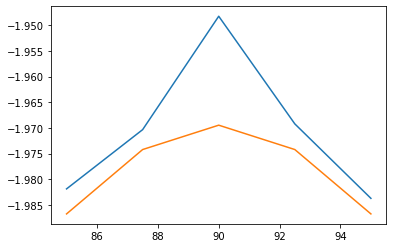

In [23]:
plt.plot(angles, results)
plt.plot(angles, exacts)

In [24]:
np.save("../../week_2_h4_uccsd.npy", (angles, results))
np.save("../../week_2_h4_exact.npy", (angles, exacts))

 It doesn't seem to be very accurate around 90 deg, even when increasing the number of trotter steps -
 is the qubit ansatz more effective?

In [44]:
def get_entanglers(molecule, n_ents):
    hf = hf_occ(2*molecule.n_orbitals, molecule.n_electrons)
    ham = molecule.make_hamiltonian()
    ranked_entangler_groupings = generate_QCC_gradient_groupings(ham.to_openfermion(),
                                                                 2*molecule.n_orbitals,
                                                                 hf,
                                                                 cutoff=threshold)

    entanglers = get_QCC_entanglers(ranked_entangler_groupings, n_ents, 2*molecule.n_orbitals)
    return entanglers, hf


def run_h4_qubit(angle: float):
    xyz = get_molecular_data('h4', angle, True)
    molecule = tq.quantumchemistry.Molecule(geometry=xyz, basis_set=basis)
    exact = molecule.compute_energy(method='fci')
    ham = molecule.make_hamiltonian()
    entanglers, hf = get_entanglers(molecule, ham.n_qubits+4)
    single_q = construct_QMF_ansatz(ham.n_qubits)
    ent_ops = construct_QCC_ansatz(entanglers)
    q_ansatz = single_q + ent_ops
    exp = tq.ExpectationValue(q_ansatz, ham)
    init = init_qcc_params(hf, exp.extract_variables())
    result = tq.minimize(objective=exp, initial_values=init, method='adam', tol=1.0e-6, print_level=1)
    return exact, result

qresults = []
qexacts = []
for a in angles:
    exact, result = run_h4_qubit(a)
    qresults.append(result.energy)
    qexacts.append(exact)

Optimizer: <class 'tequila.optimizers.optimizer_gd.OptimizerGD'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Objective       : 1 expectationvalues
Gradient        : 56 expectationvalues
gradient instr  : None
active variables : 28
Iteration: 1 , Energy: -1.92949208, angles: {beta_0: 3.141592653589793, gamma_0: 0.0, beta_1: 3.141592653589793, gamma_1: 0.0, beta_2: 3.141592653589793, gamma_2: 0.0, beta_3: 3.141592653589793, gamma_3: 0.0, beta_4: 0.0, gamma_4: 0.0, beta_5: 0.0, gamma_5: 0.0, beta_6: 0.0, gamma_6: 0.0, beta_7: 0.0, gamma_7: 0.0, tau_0: 0.09999993089399109, tau_1: 0.0999999242924437, tau_2: 0.0999999242924437, tau_3: 0.0999999229796198, tau_4: 0.09999988494458383, tau_5: -0.09999988260577354, tau_6: -0.09999988260577354, tau_7: 0.09999988028371427, tau_8: -0.09999978679995945, tau_9: -0.09999978679995945, tau_10: 0.09999993089399109, tau_11: 0.0999999242924437}
Iteration: 2 , Energy: -1.94061565, angles: {beta_0: 3.1415926

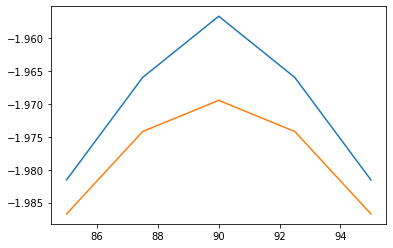

In [46]:
plt.plot(angles, qresults)
plt.plot(angles, qexacts)

In [47]:
np.save("../../week_2_h4_qansatz.npy", (angles, qresults))